In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer

# Load dataset
df = pd.read_csv('/content/final.csv')

# Check for missing values
df.dropna(subset=['caption', 'category'], inplace=True)

# Map categories to integers
label_mapping = {'Harmful Content': 0, 'safe': 1, 'suicide': 2}
df['category'] = df['category'].map(label_mapping)

# Split data into features and labels
captions = df['caption'].values
categories = df['category'].values

# Tokenizer setup (using transformers' AutoTokenizer)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
max_seq_length = 128

def tokenize_data(texts, labels):
    encodings = tokenizer(list(texts), truncation=True, padding='max_length', max_length=max_seq_length, return_tensors="pt")
    return encodings['input_ids'], encodings['attention_mask'], torch.tensor(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(captions, categories, test_size=0.2, random_state=42)
input_ids_train, attention_masks_train, labels_train = tokenize_data(X_train, y_train)
input_ids_test, attention_masks_test, labels_test = tokenize_data(X_test, y_test)

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'label': self.labels[idx]
        }

# Create DataLoader
def create_dataloader(input_ids, attention_masks, labels, batch_size):
    dataset = CustomDataset(input_ids, attention_masks, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(input_ids_train, attention_masks_train, labels_train, batch_size=32)
test_loader = create_dataloader(input_ids_test, attention_masks_test, labels_test, batch_size=32)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(categories), y=categories)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Define a custom SSM-like layer
class SimpleSSMLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleSSMLayer, self).__init__()
        self.dense = nn.Linear(input_dim, output_dim)
        self.layer_norm = nn.LayerNorm(output_dim)

    def forward(self, x):
        x = F.relu(self.dense(x))
        x = self.layer_norm(x)
        return x

# Define the model
class SSMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(SSMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.ssm1 = SimpleSSMLayer(embed_dim, 128)
        self.ssm2 = SimpleSSMLayer(128, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = torch.mean(x, dim=1)  # Mean pooling
        x = self.ssm1(x)
        x = self.dropout(x)
        x = self.ssm2(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Model setup
vocab_size = tokenizer.vocab_size
embed_dim = 128
num_classes = len(label_mapping)
model = SSMModel(vocab_size, embed_dim, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label']

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluation loop
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label']

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy}")

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch 1, Loss: 1.153828198812446
Epoch 2, Loss: 1.0209772002940276
Epoch 3, Loss: 0.9135153451744391
Epoch 4, Loss: 0.7686771081418408
Epoch 5, Loss: 0.6619342687178631
Epoch 6, Loss: 0.6141950615814754
Epoch 7, Loss: 0.5079639955442778
Epoch 8, Loss: 0.5264582390687904
Epoch 9, Loss: 0.4422492999203351
Epoch 10, Loss: 0.41926168239846523
Test Accuracy: 0.8112244897959183


Saving final.csv to final (1).csv
Epoch 1, Loss: 0.9316843918391636
Epoch 2, Loss: 0.6411683018110237
Epoch 3, Loss: 0.5024209898345324
Epoch 4, Loss: 0.4131111882779063
Epoch 5, Loss: 0.35239458175338045
Epoch 6, Loss: 0.3043702310141252
Epoch 7, Loss: 0.2691675609319794
Epoch 8, Loss: 0.260831884735701
Epoch 9, Loss: 0.2239543997815677
Epoch 10, Loss: 0.19634688368105158
Test Accuracy: 0.8494897959183674


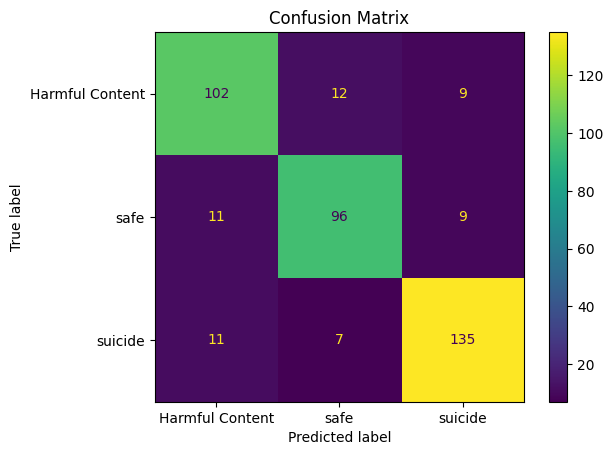

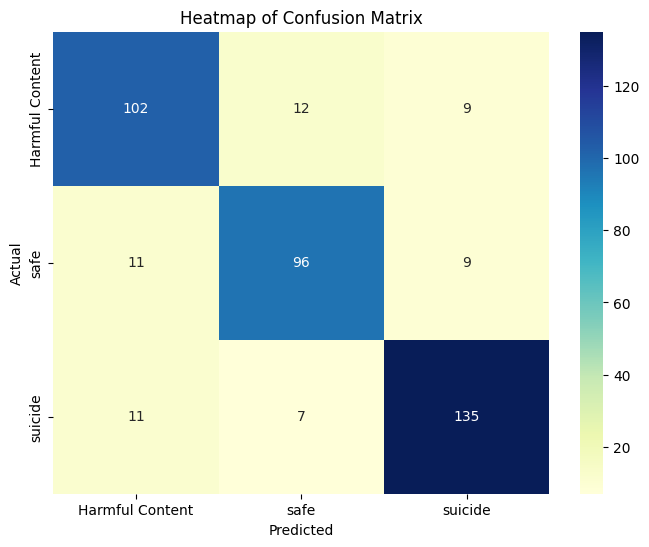

In [ ]:
# Install necessary libraries
!pip install transformers torch seaborn scikit-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt

# Upload and load dataset
from google.colab import files
uploaded = files.upload()  # Upload 'final.csv' from your local machine

df = pd.read_csv('final.csv')

# Check for missing values
df.dropna(subset=['caption', 'category'], inplace=True)

# Map categories to integers
label_mapping = {'Harmful Content': 0, 'safe': 1, 'suicide': 2}
df['category'] = df['category'].map(label_mapping)

# Split data into features and labels
captions = df['caption'].values
categories = df['category'].values

# Tokenizer setup (using transformers' AutoTokenizer)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
max_seq_length = 128

def tokenize_data(texts, labels):
    encodings = tokenizer(list(texts), truncation=True, padding='max_length', max_length=max_seq_length, return_tensors="pt")
    return encodings['input_ids'], encodings['attention_mask'], torch.tensor(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(captions, categories, test_size=0.2, random_state=42)
input_ids_train, attention_masks_train, labels_train = tokenize_data(X_train, y_train)
input_ids_test, attention_masks_test, labels_test = tokenize_data(X_test, y_test)

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'label': self.labels[idx]
        }

# Create DataLoader
def create_dataloader(input_ids, attention_masks, labels, batch_size):
    dataset = CustomDataset(input_ids, attention_masks, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(input_ids_train, attention_masks_train, labels_train, batch_size=32)
test_loader = create_dataloader(input_ids_test, attention_masks_test, labels_test, batch_size=32)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(categories), y=categories)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Define a custom SSM-like layer
class SimpleSSMLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleSSMLayer, self).__init__()
        self.dense = nn.Linear(input_dim, output_dim)
        self.layer_norm = nn.LayerNorm(output_dim)

    def forward(self, x):
        x = F.relu(self.dense(x))
        x = self.layer_norm(x)
        return x

# Define the model
class SSMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(SSMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.ssm1 = SimpleSSMLayer(embed_dim, 128)
        self.ssm2 = SimpleSSMLayer(128, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = x * attention_mask.unsqueeze(-1)  # Mask padded embeddings
        x = torch.mean(x, dim=1)  # Mean pooling
        x = self.ssm1(x)
        x = self.dropout(x)
        x = self.ssm2(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = tokenizer.vocab_size
embed_dim = 128
num_classes = len(label_mapping)
model = SSMModel(vocab_size, embed_dim, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluation loop
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())
    disp.plot(cmap='viridis')
    plt.title('Confusion Matrix')
    plt.show()

    # Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Heatmap of Confusion Matrix')
    plt.show()

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)


In [ ]:
print(model)

SSMModel(
  (embedding): Embedding(30522, 128)
  (ssm1): SimpleSSMLayer(
    (dense): Linear(in_features=128, out_features=128, bias=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (ssm2): SimpleSSMLayer(
    (dense): Linear(in_features=128, out_features=64, bias=True)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)


Classification Report:

                 precision  recall  f1-score  support
Harmful Content        1.0     1.0       1.0     90.0
safe                   1.0     1.0       1.0     90.0
suicide                1.0     1.0       1.0     90.0
accuracy               1.0     1.0       1.0      1.0
macro avg              1.0     1.0       1.0    270.0
weighted avg           1.0     1.0       1.0    270.0


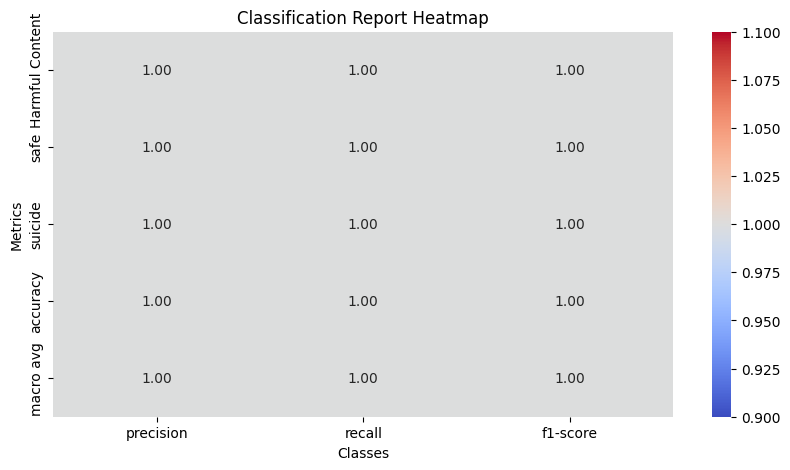

In [ ]:
# Import required libraries
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you have true labels and predicted labels
# Replace these with your actual data
true_labels = ['Harmful Content', 'safe', 'suicide'] * 90  # Replace with actual labels
predicted_labels = ['Harmful Content', 'safe', 'suicide'] * 90  # Replace with your model predictions

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Harmful Content', 'safe', 'suicide'], output_dict=True)

# Convert the classification report into a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Display the classification report
print("Classification Report:\n")
print(report_df)

# Plotting the classification report as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Classification Report Heatmap")
plt.ylabel("Metrics")
plt.xlabel("Classes")
plt.show()


In [ ]:
from google.colab import files

# Save the trained model to a file
model_path = "best_model.pth"
torch.save(model, model_path)

# Download the model file
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
from transformers import AutoTokenizer

# Load the trained model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("best_model.pth", map_location=device)  # Load your trained model
model.eval()

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def predict_category(caption):
    """Predicts the category for a given caption."""
    # Tokenize the input
    inputs = tokenizer(caption, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Remove 'token_type_ids' if present
    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        # Get the model's output
        outputs = model(**inputs)  # This should return raw logits as a Tensor

    # Apply softmax to the raw logits to get probabilities
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class

# Example usage
sample_caption = "I want to kill myself"
predicted_class = predict_category(sample_caption)
category_mapping = {0: "Harmful Content", 1: "Safe", 2: "Suicide"}  # Adjust based on your label encoding
print(f"Predicted Category: {category_mapping[predicted_class]}")


<ipython-input-10-a5042f4d1a8a>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_model.pth", map_location=device)  # Load your trained model


Predicted Category: Safe
